Lujain Madi Ali Al-Smadi   32009303047

This notebook is for training the model

# **Importing Libraries and Setting Up Environment**

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

modules loaded


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# **Downloading and Extracting Dataset**

In [ ]:
!kaggle datasets download -d anshtanwar/pets-facial-expression-dataset

Dataset URL: https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 38.0M/38.6M [00:00<00:00, 85.6MB/s]
100% 38.6M/38.6M [00:00<00:00, 83.3MB/s]


In [ ]:
# Unzip training set
local_zip = '/content/pets-facial-expression-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./pets-facial-expression-dataset')


zip_ref.close()

In [ ]:
train_data_dir = '/content/pets-facial-expression-dataset/Master Folder/train'
valid_data_dir = '/content/pets-facial-expression-dataset/Master Folder/valid'
test_data_dir = '/content/pets-facial-expression-dataset/Master Folder/test'

data_dir = '/content/pets-facial-expression-dataset'


ds_name = 'Pets Facial Expression'

# **Data Path and DataFrame Creation**

In [ ]:
# Generate data paths with labels

def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        if fold == 'Master Folder':
            continue

        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

#**Data Information and Splitting**

In [ ]:
df.head()

,filepaths,labels
0,/content/pets-facial-expression-dataset/happy/...,happy
1,/content/pets-facial-expression-dataset/happy/...,happy
2,/content/pets-facial-expression-dataset/happy/...,happy
3,/content/pets-facial-expression-dataset/happy/...,happy
4,/content/pets-facial-expression-dataset/happy/...,happy


In [ ]:
#images numbers
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Pets Facial Expression dataset has 1000 images.


In [ ]:
#classes numbers
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Pets Facial Expression dataset has 4 classes


In [ ]:
#numbers of images for each class
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Pets Facial Expression dataset has: 

Class 'happy' has 250 images
----------------------------------------------------------------------
Class 'Angry' has 250 images
----------------------------------------------------------------------
Class 'Sad' has 250 images
----------------------------------------------------------------------
Class 'Other' has 250 images
----------------------------------------------------------------------


In [ ]:
#Split dataframe into train, valid, and test
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
num_of_examples(train_df, "Training "+ds_name)
num_of_examples(valid_df, "Validation "+ds_name)
num_of_examples(test_df, "Testing "+ds_name)

The Training Pets Facial Expression dataset has 800 images.
The Validation Pets Facial Expression dataset has 120 images.
The Testing Pets Facial Expression dataset has 80 images.


In [ ]:
classes_count(train_df, 'Training '+ds_name)

The Training Pets Facial Expression dataset has: 

Class 'Sad' has 209 images
----------------------------------------------------------------------
Class 'Other' has 192 images
----------------------------------------------------------------------
Class 'Angry' has 201 images
----------------------------------------------------------------------
Class 'happy' has 198 images
----------------------------------------------------------------------


In [ ]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Pets Facial Expression dataset has: 

Class 'Angry' has 29 images
----------------------------------------------------------------------
Class 'Sad' has 28 images
----------------------------------------------------------------------
Class 'happy' has 35 images
----------------------------------------------------------------------
Class 'Other' has 28 images
----------------------------------------------------------------------


In [ ]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Pets Facial Expression dataset has: 

Class 'happy' has 17 images
----------------------------------------------------------------------
Class 'Angry' has 20 images
----------------------------------------------------------------------
Class 'Other' has 30 images
----------------------------------------------------------------------
Class 'Sad' has 13 images
----------------------------------------------------------------------


#**Data Augmentation and Generators**

In [ ]:
#Create Image Data Generator
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 800 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


#**Visualizing Training Data**

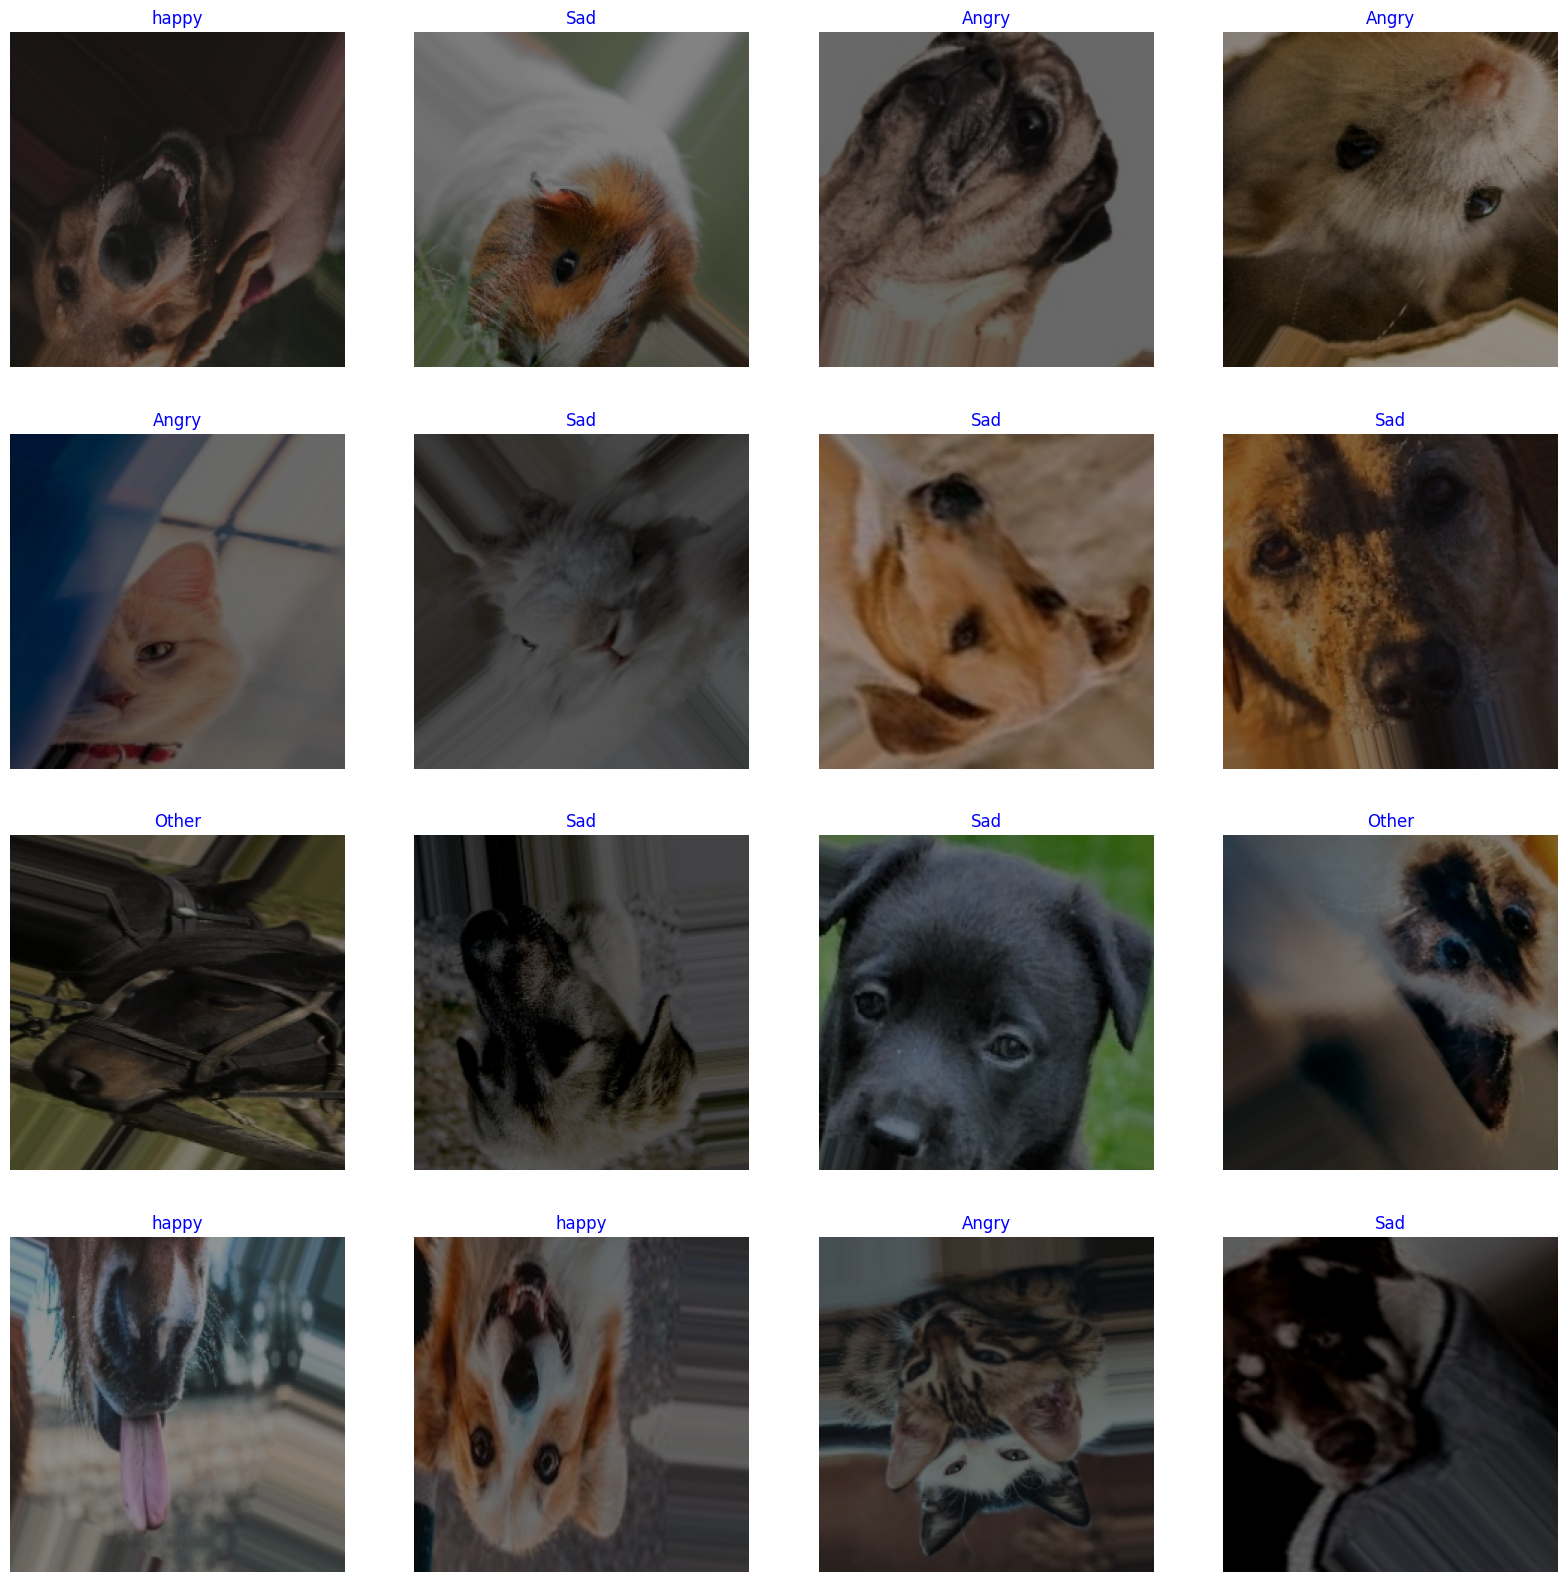

In [ ]:
#Visualize Training dataset
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

#**Model Definition and Training**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()


115263384/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                       

In [ ]:
batch_size = 64   # set batch size for training
history = model.fit(x=train_gen,
                    epochs= 100,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False)

Epoch 1/100
50/50 [==============================] - 303s 6s/step - loss: 4.6499 - accuracy: 0.3525 - val_loss: 4.5260 - val_accuracy: 0.4333
Epoch 2/100
50/50 [==============================] - 299s 6s/step - loss: 4.3256 - accuracy: 0.4025 - val_loss: 4.1348 - val_accuracy: 0.4417
Epoch 3/100
50/50 [==============================] - 290s 6s/step - loss: 4.1500 - accuracy: 0.4013 - val_loss: 3.9697 - val_accuracy: 0.5000
Epoch 4/100
50/50 [==============================] - 298s 6s/step - loss: 3.9561 - accuracy: 0.4663 - val_loss: 3.8323 - val_accuracy: 0.4750
Epoch 5/100
50/50 [==============================] - 289s 6s/step - loss: 3.8383 - accuracy: 0.4800 - val_loss: 3.6431 - val_accuracy: 0.5917
Epoch 6/100
50/50 [==============================] - 297s 6s/step - loss: 3.6634 - accuracy: 0.5163 - val_loss: 3.5137 - val_accuracy: 0.5750
Epoch 7/100
50/50 [==============================] - 285s 6s/step - loss: 3.5690 - accuracy: 0.5300 - val_loss: 3.4212 - val_accuracy: 0.6250
Epoch 

# **Evaluating Model Performance**

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

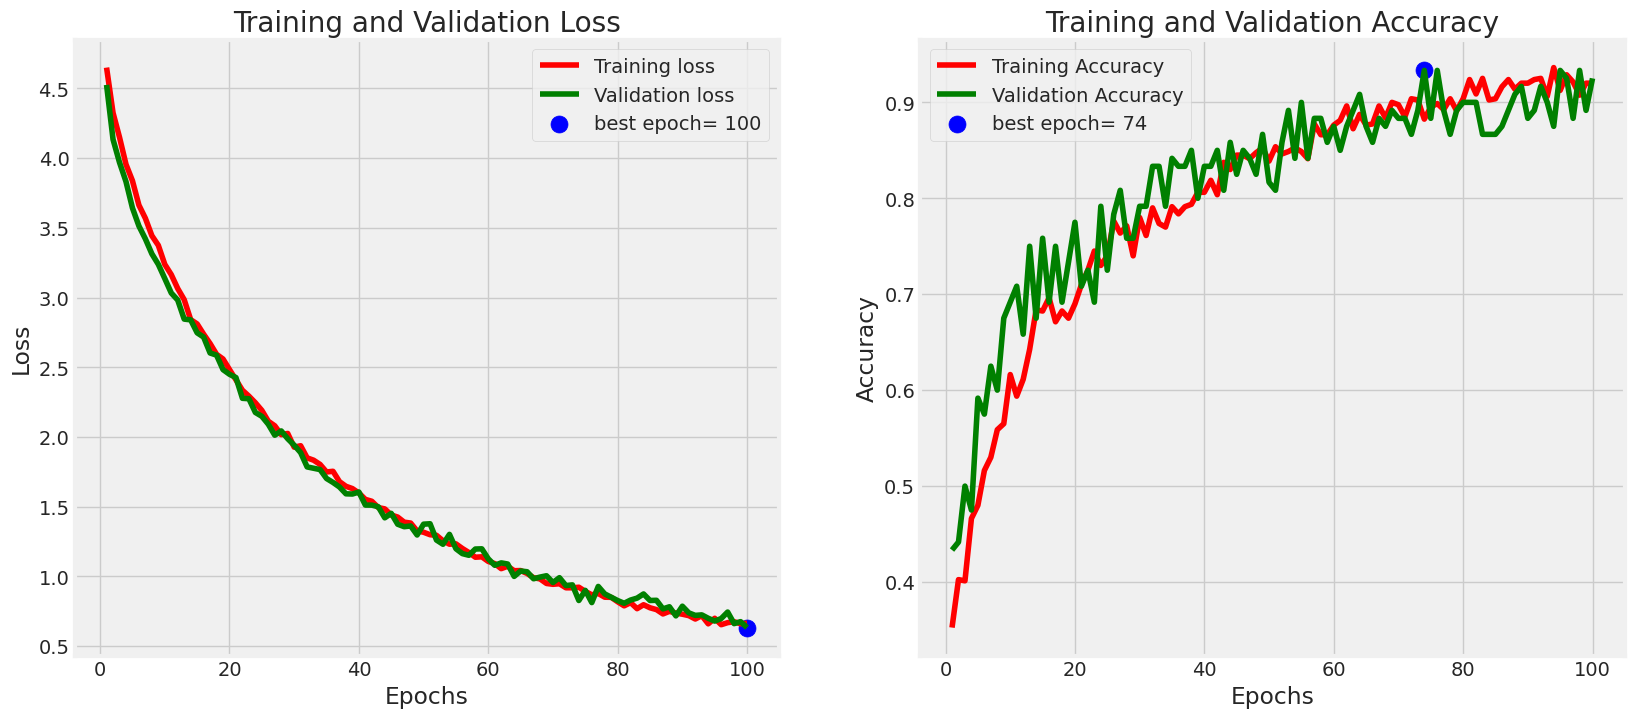

In [ ]:
# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

#**Making Predictions and Saving Model**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
classes = ["HAPPY", "SAD", "ANGRY","OTHER"]

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       HAPPY       0.95      0.95      0.95        20
         SAD       0.97      0.97      0.97        30
       ANGRY       0.92      0.92      0.92        13
       OTHER       0.94      0.94      0.94        17

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



In [ ]:
model.save_weights('Pets_Facial_Expression_model.h5')